In [1]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.evaluation import evaluate_policy

import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from IPython.display import display, Markdown

import scipy.stats as st

import matplotlib.pyplot as plt

In [2]:
total_timesteps = 2000000
env_kwargs={'enable_wind':True, 'wind_power': 15, 'turbulence_power': 1.5}

In [3]:
def agent_eval(agent, n_eval_episodes=25, seed=42, verbose=1):
    eval_env = make_vec_env("LunarLander-v2", n_envs=16, seed=seed, env_kwargs=env_kwargs)
    reward_length = evaluate_policy(agent, eval_env, 
                           return_episode_rewards=True,
                           n_eval_episodes=n_eval_episodes,
                           deterministic=True)
    for i, p in enumerate(["mean", "length"]):
        mean = np.mean(reward_length[i])
        if verbose:
            sem = st.sem(reward_length[i])
            mean_CI = st.t.interval(0.95, df=len(reward_length[i])-1, loc=mean, scale=sem) 
        
            print(f"mean_{p}={mean:.3f}, SEM={sem}, CI=[{mean_CI[0]:.3f}:{mean_CI[1]:.3f}]")

    return np.mean(reward_length[0])

In [4]:
def _save_frames_as_gif(frames, path="./", filename="gym_animation.gif", fps=60):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=fps)

def _add_text_info(frame, episode_num, step, reward):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), 
                f"Episode: {episode_num+1}\nStep: {step}\nCurrent reward: {reward}", 
                fill=text_color)
    return im

def save_trained_agent_gif(agent, path="./", filename="trained_agent.gif", n=1, fps=60):
    env = gym.make("LunarLander-v2", render_mode="rgb_array", enable_wind=False, wind_power=15.0, turbulence_power=1.5,)
    
    frames = []
    for i in range(n):
        R = 0
        observation, _ = env.reset()        
        for t in range(500):
            action, _ = agent.predict(observation, None, None, True)
            observation, reward, terminated, _, _ = env.step(action)
            R += reward
            frame = env.render()
            frames.append(_add_text_info(frame, episode_num=i, step=t, reward=R))
            if terminated:
                frames.extend([_add_text_info(frame, episode_num=i, step=t, reward=R)]*25)
                break
    
    env.close()

    _save_frames_as_gif(frames, path=path, filename=filename, fps=fps)

In [5]:
class RandomAgent(object):
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self._rng = np.random.default_rng(None)

    def predict(self, observations, state, episode_start, deterministic):
        rng = self.rng if deterministic else self._rng
        if len(observations.shape) == 1:
            return rng.integers(4, size=1)[0], None
        else: 
            return rng.integers(4, size=observations.shape[0]), None

In [6]:
agent_eval(RandomAgent(42))

mean_mean=-298.785, SEM=27.16139989247302, CI=[-354.843:-242.726]
mean_length=85.880, SEM=4.000549962192698, CI=[77.623:94.137]


-298.78486372

In [7]:
save_trained_agent_gif(RandomAgent(42), filename="random_agent.gif", n=2, fps=60)
#display(Markdown(f"<img src='random_agent.gif'>"))

In [8]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    fig = plt.figure(title, figsize=(10, 5))
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    min_x, max_x = min(x), max(x)
    plt.scatter(x, y, s=1)
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    plt.plot(x, y, color="black")
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " (Smoothed)")
    plt.xlim(min_x, max_x)
    plt.show()

In [9]:
# Define the callback function
class CustomCallback(BaseCallback):
    def __init__(self, log_dir: str, verbose=1):
        super(CustomCallback, self).__init__(verbose)
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
        self.done_eps = 0

    def _check(self):
        results = load_results(self.log_dir)
        new_eps = len(results) - self.done_eps
        self.done_eps = len(results)
        x, y = ts2xy(results, 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-new_eps:])
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                if self.verbose > 0:
                    print(f"New best mean reward: {mean_reward:.2f}, eval_episodes: {new_eps}, total_steps: {self.num_timesteps}, total_episodes: {self.done_eps}")
                    self.model.save(self.save_path)

    def _init_callback(self) -> None:
        if self.log_dir is not None:
            os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        # if self.n_calls % self.check_freq == 0:
        #   self._check()
        return True

    def _on_training_end(self) -> None:
        interim_mean = agent_eval(self.model.load(self.save_path), verbose=0)
        final_mean = agent_eval(self.model, verbose=0)

        if interim_mean > final_mean:
            print(f"Interim model was better.")
            self.model.set_parameters(self.save_path)

        self.model.save(self.log_dir)

    def _on_rollout_end(self) -> None:
        self._check()

## PPO-Baseline

In [10]:
model_dir = "./models/PPO_baseline"

#env = gym.make("LunarLander-v2", continuous=False)

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir, env_kwargs=env_kwargs)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")

# Load the model
# loaded_model = PPO.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v01_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

New best mean reward: -279.78, eval_episodes: 358, total_steps: 32768, total_episodes: 358
New best mean reward: -242.52, eval_episodes: 353, total_steps: 65536, total_episodes: 711
New best mean reward: -207.49, eval_episodes: 356, total_steps: 98304, total_episodes: 1067
New best mean reward: -147.59, eval_episodes: 323, total_steps: 131072, total_episodes: 1390
New best mean reward: -116.58, eval_episodes: 317, total_steps: 163840, total_episodes: 1707
New best mean reward: -84.34, eval_episodes: 307, total_steps: 196608, total_episodes: 2014
New best mean reward: -70.28, eval_episodes: 310, total_steps: 229376, total_episodes: 2324
New best mean reward: -56.46, eval_episodes: 260, total_steps: 262144, total_episodes: 2584
New best mean reward: -50.18, eval_episodes: 191, total_steps: 294912, total_episodes: 2775
New best mean reward: -37.32, eval_episodes: 163, total_steps: 327680, total_episodes: 2938
New best mean reward: -20.88, eval_episodes: 99, total_steps: 393216, total_epis

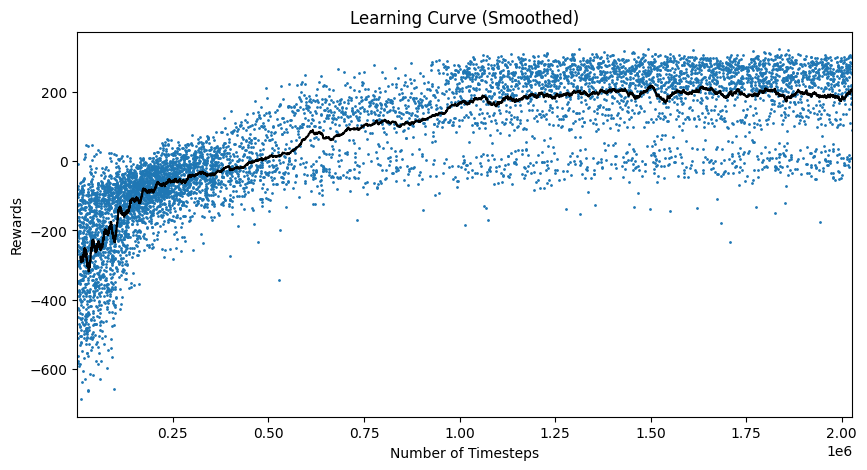

In [11]:
plot_results(model_dir)

In [12]:
agent_eval(model)

mean_mean=192.916, SEM=19.7571230750207, CI=[152.140:233.693]
mean_length=397.160, SEM=55.78164811716006, CI=[282.032:512.288]


192.91623592

In [13]:
save_trained_agent_gif(model, filename="ppo_baseline.gif", n=2, fps=60)
#display(Markdown(f"<img src='ppo_baseline.gif'>"))

## PPO-Tuned

In [14]:
model_dir = "./models/PPO_tuned"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir, env_kwargs=env_kwargs)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    verbose=0, 
    tensorboard_log="./tb_logs/"
)
callback = CustomCallback(log_dir=model_dir)

model.learn(total_timesteps=total_timesteps, callback=callback, tb_log_name="v02_10k")

New best mean reward: -253.04, eval_episodes: 85, total_steps: 8192, total_episodes: 85
New best mean reward: -222.15, eval_episodes: 91, total_steps: 24576, total_episodes: 266
New best mean reward: -197.77, eval_episodes: 90, total_steps: 32768, total_episodes: 356
New best mean reward: -191.56, eval_episodes: 88, total_steps: 40960, total_episodes: 444
New best mean reward: -172.25, eval_episodes: 87, total_steps: 49152, total_episodes: 531
New best mean reward: -138.13, eval_episodes: 90, total_steps: 57344, total_episodes: 621
New best mean reward: -124.20, eval_episodes: 87, total_steps: 81920, total_episodes: 876
New best mean reward: -112.11, eval_episodes: 85, total_steps: 90112, total_episodes: 961
New best mean reward: -105.10, eval_episodes: 87, total_steps: 98304, total_episodes: 1048
New best mean reward: -87.50, eval_episodes: 87, total_steps: 106496, total_episodes: 1135
New best mean reward: -76.52, eval_episodes: 89, total_steps: 122880, total_episodes: 1315
New best 

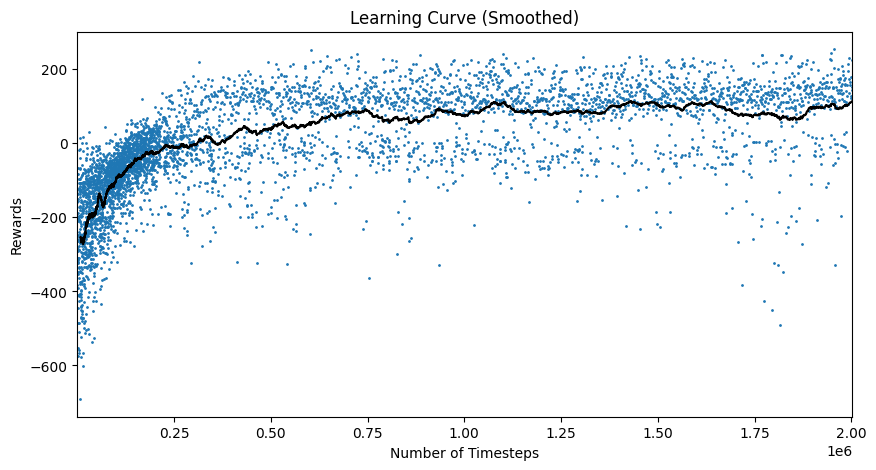

In [15]:
plot_results(model_dir)

In [16]:
agent_eval(model)

mean_mean=116.271, SEM=33.52099320401031, CI=[47.087:185.455]
mean_length=402.520, SEM=40.494325528399656, CI=[318.944:486.096]


116.27113996

In [17]:
save_trained_agent_gif(model, filename="ppo_v2.gif", n=2, fps=60)
#display(Markdown(f"<img src='ppo_v2.gif'>"))

## DQN-Baseline

In [18]:
model_dir = "./models/DQN_baseline"

#env = gym.make("LunarLander-v2", continuous=False)

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir, env_kwargs=env_kwargs)

# Create the DQN model
model = DQN("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")

# Load the model
# loaded_model = DQN.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v03_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -335.81, eval_episodes: 1, total_steps: 1024, total_episodes: 1
New best mean reward: -232.70, eval_episodes: 2, total_steps: 1152, total_episodes: 3
New best mean reward: -218.65, eval_episodes: 1, total_steps: 1344, total_episodes: 4
New best mean reward: -211.42, eval_episodes: 2, total_steps: 1408, total_episodes: 6


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -117.47, eval_episodes: 1, total_steps: 1984, total_episodes: 13
New best mean reward: -96.85, eval_episodes: 1, total_steps: 2048, total_episodes: 14
New best mean reward: -79.17, eval_episodes: 1, total_steps: 2176, total_episodes: 16


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


New best mean reward: -56.21, eval_episodes: 1, total_steps: 8832, total_episodes: 91
New best mean reward: 19.13, eval_episodes: 1, total_steps: 9728, total_episodes: 100
New best mean reward: 36.26, eval_episodes: 1, total_steps: 119296, total_episodes: 1014
New best mean reward: 98.80, eval_episodes: 1, total_steps: 538880, total_episodes: 1832
New best mean reward: 110.28, eval_episodes: 1, total_steps: 602560, total_episodes: 1908
New best mean reward: 142.65, eval_episodes: 1, total_steps: 1210048, total_episodes: 3259
Interim model was better.


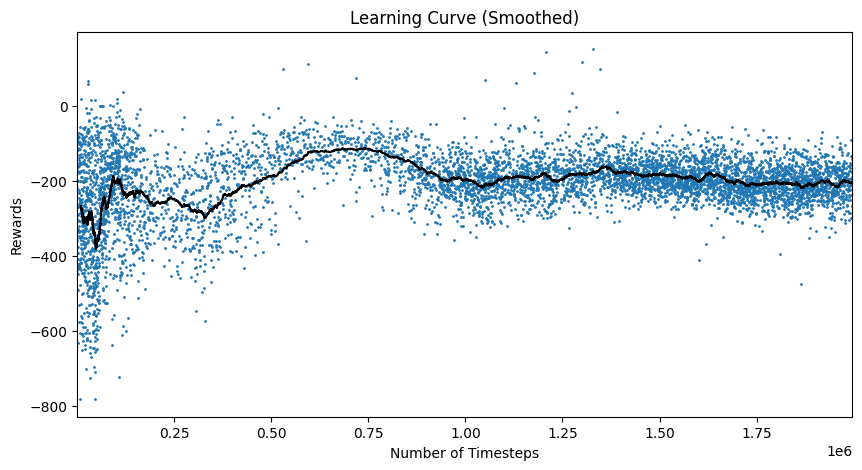

In [19]:
plot_results(model_dir)

In [20]:
agent_eval(model)

mean_mean=-182.159, SEM=15.913924731992978, CI=[-215.004:-149.315]
mean_length=258.720, SEM=31.615635372391303, CI=[193.469:323.971]


-182.15949488

In [21]:
save_trained_agent_gif(model, filename="dqn_baseline.gif", n=2, fps=60)
#display(Markdown(f"<img src='dqn_baseline.gif'>"))

## DQN-Tuned

In [22]:
model_dir = "./models/DQN_tuned"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir, env_kwargs=env_kwargs)

# Create the DQN model
model = DQN(
    env=env,
    batch_size=128,
    #buffer_size=50000,
    exploration_final_eps=0.1,
    exploration_fraction=0.12,
    #gamma=0.99,
    #gradient_steps=-1,
    learning_rate=0.00063,
    #learning_starts=0,
    policy="MlpPolicy",
    #policy_kwargs=dict(net_arch=[256, 256]),
    #target_update_interval=250,
    #train_freq=4,
    verbose=0,
    tensorboard_log="./tb_logs/"
)

# Load the model
# loaded_model = DQN.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v04_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -152.77, eval_episodes: 2, total_steps: 1024, total_episodes: 2
New best mean reward: -65.54, eval_episodes: 1, total_steps: 1088, total_episodes: 3


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: 45.00, eval_episodes: 1, total_steps: 7424, total_episodes: 78
New best mean reward: 55.71, eval_episodes: 1, total_steps: 10496, total_episodes: 109
New best mean reward: 62.79, eval_episodes: 1, total_steps: 129856, total_episodes: 1197
New best mean reward: 76.32, eval_episodes: 1, total_steps: 138112, total_episodes: 1257
New best mean reward: 92.53, eval_episodes: 1, total_steps: 163712, total_episodes: 1412
New best mean reward: 176.46, eval_episodes: 1, total_steps: 173504, total_episodes: 1458
New best mean reward: 186.31, eval_episodes: 1, total_steps: 205568, total_episodes: 1564
New best mean reward: 196.06, eval_episodes: 1, total_steps: 205632, total_episodes: 1565
New best mean reward: 216.86, eval_episodes: 1, total_steps: 214784, total_episodes: 1586
New best mean reward: 217.88, eval_episodes: 1, total_steps: 241792, total_episodes: 1642
New best mean reward: 236.44, eval_episodes: 1, total_steps: 320704, total_episodes: 1816
New best mean reward:

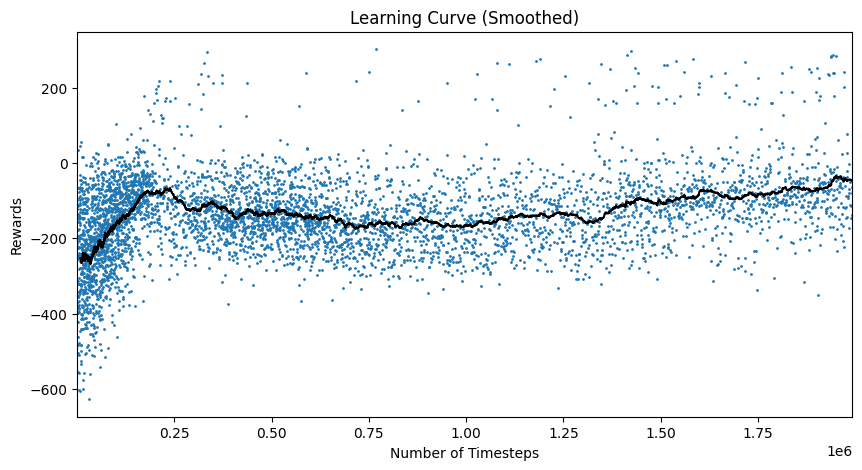

In [23]:
plot_results(model_dir)

In [24]:
agent_eval(model)

mean_mean=-107.559, SEM=16.567050232162657, CI=[-141.751:-73.366]
mean_length=919.440, SEM=31.50545349618063, CI=[854.416:984.464]


-107.5586722

In [25]:
save_trained_agent_gif(model, filename="dqn_v02.gif", n=2, fps=60)
#display(Markdown(f"<img src='dqn_v02.gif'>"))

In [23]:
def test_adaptability(agent, n_eval_episodes=50, seed=42, verbose=1, env_kwargs=env_kwargs):
    eval_env = make_vec_env("LunarLander-v2", n_envs=16, seed=seed, env_kwargs=env_kwargs)
    reward_length = evaluate_policy(agent, eval_env, 
                           return_episode_rewards=True,
                           n_eval_episodes=n_eval_episodes,
                           deterministic=True)
    for i, p in enumerate(["mean", "length"]):
        mean = np.mean(reward_length[i])
        if verbose:
            sem = st.sem(reward_length[i])
            mean_CI = st.t.interval(0.95, df=len(reward_length[i])-1, loc=mean, scale=sem) 
        
            print(f"mean_{p}={mean:.3f}, SEM={sem}, CI=[{mean_CI[0]:.3f}:{mean_CI[1]:.3f}]")

    return np.mean(reward_length[0])

easy_env = {'enable_wind':False, 'turbulence_power': 0.0}
medium_env = {'enable_wind':True, 'wind_power': 10, 'turbulence_power': 1.0}
training_env = {'enable_wind':True, 'wind_power': 15, 'turbulence_power': 1.5}
hard_env = {'enable_wind':True, 'wind_power': 20, 'turbulence_power': 2.0}

envs = [easy_env, medium_env, training_env, hard_env]
agents = [(PPO.load("models/PPO_baseline.zip"), "PPO baseline"), (PPO.load("models/PPO_tuned.zip"), "PPO tuned"), (DQN.load("models/DQN_baseline.zip"), "DQN baseline"), (DQN.load("models/DQN_tuned.zip"), "DQN tuned")]
for env in envs:
    print(f"Environment: {env}")
    for model, name in agents:
        print(f"Model: {name}")
        test_adaptability(model, env_kwargs=env)




/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


Environment: {'enable_wind': False, 'turbulence_power': 0.0}
Model: PPO baseline
mean_mean=237.634, SEM=7.838962814200479, CI=[221.881:253.387]
mean_length=321.820, SEM=30.482710924491652, CI=[260.563:383.077]
Model: PPO tuned
mean_mean=206.391, SEM=10.848858264608994, CI=[184.589:228.192]
mean_length=474.500, SEM=27.92519526542733, CI=[418.382:530.618]
Model: DQN baseline
mean_mean=-153.800, SEM=5.0361765066655515, CI=[-163.920:-143.679]
mean_length=250.300, SEM=14.666225256190025, CI=[220.827:279.773]
Model: DQN tuned
mean_mean=-45.737, SEM=9.455070099927397, CI=[-64.738:-26.736]
mean_length=985.880, SEM=6.03984322002227, CI=[973.742:998.018]
Environment: {'enable_wind': True, 'wind_power': 10, 'turbulence_power': 1.0}
Model: PPO baseline
mean_mean=227.993, SEM=8.145982906714778, CI=[211.623:244.363]
mean_length=388.560, SEM=37.359141274053584, CI=[313.484:463.636]
Model: PPO tuned
mean_mean=185.063, SEM=18.871003106187164, CI=[147.141:222.986]
mean_length=482.840, SEM=31.46424417055

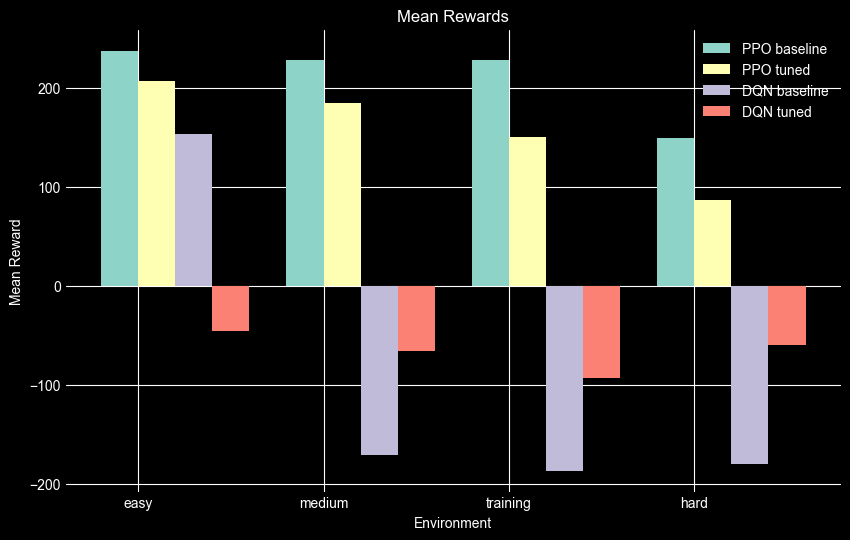

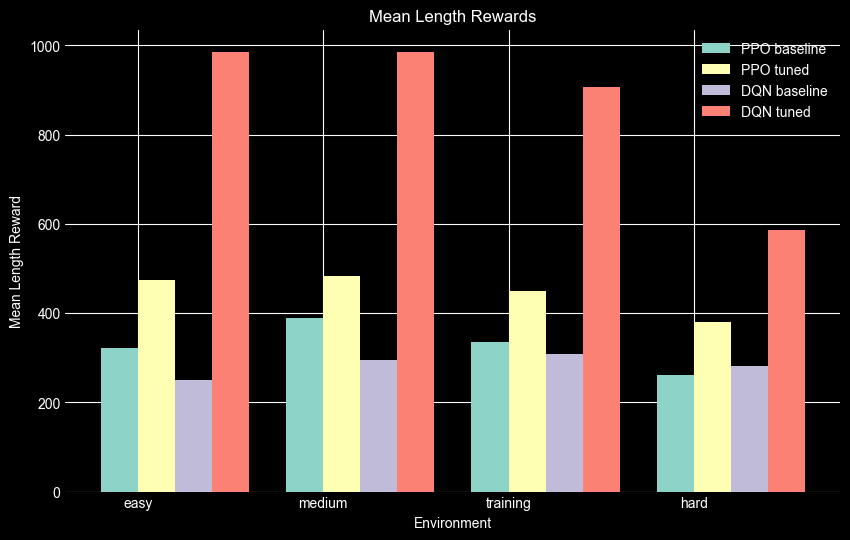

In [36]:
mean_rewards = {
    "PPO baseline": [237.634, 227.993, 228.206, 149.254],
    "PPO tuned": [206.391, 185.063, 150.251, 86.899],
    "DQN baseline": [153.800, -170.665, -186.874, -180.557],
    "DQN tuned": [-45.737, -65.781, -93.323, -60.096]
}

mean_length_rewards = {
    "PPO baseline": [321.820, 388.560, 334.880, 260.780],
    "PPO tuned": [474.500, 482.840, 448.340, 380.820],
    "DQN baseline": [250.300, 294.080, 308.060, 282.220],
    "DQN tuned": [985.880, 984.940, 906.900, 585.660]
}

env_names = ['easy', 'medium', 'training', 'hard']
bar_width = 0.2
plt.style.use('dark_background')

# Create a new figure for the mean_rewards plot
plt.figure(figsize=(10, 6))
for i, (name, rewards) in enumerate(mean_rewards.items()):
    plt.bar(np.arange(len(env_names)) + i * bar_width, rewards, width=bar_width, label=name)

plt.title('Mean Rewards')
plt.xlabel('Environment')
plt.ylabel('Mean Reward')
plt.xticks(np.arange(len(env_names)) + bar_width / 2, env_names)  # set the x-ticks to be the environment names
plt.legend()
plt.show()

# Create a new figure for the mean_length_rewards plot
plt.figure(figsize=(10, 6))
for i, (name, rewards) in enumerate(mean_length_rewards.items()):
    plt.bar(np.arange(len(env_names)) + i * bar_width, rewards, width=bar_width, label=name)

plt.title('Mean Length Rewards')
plt.xlabel('Environment')
plt.ylabel('Mean Length Reward')
plt.xticks(np.arange(len(env_names)) + bar_width / 2, env_names)  # set the x-ticks to be the environment names
plt.legend()
plt.show()